In [1]:
# My code
import fast_gillespie as fg
import fast_gillespie_viz as fgv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
#Define cooperative binding trimer

# Rates in terms of interpretable quantities
mean_num_A_monomers = 100.0
mean_num_C_monomers = 100.0  
mean_num_dimers= 50.0
mean_num_trimers = 30.0
rate1p = mean_num_A_monomers
rate1m = 1.0
rate2p = mean_num_C_monomers
rate2m = 1.0
rate3p = 3*mean_num_dimers/(2*mean_num_A_monomers*mean_num_C_monomers)
rate3m = 3*1.0
rate4p = 0.5*mean_num_trimers/((mean_num_C_monomers)*mean_num_dimers)
rate4m = 0.5*0.5

# Print out rate-determining quantities
print('mean_num_A_monomers = ', mean_num_A_monomers)
print('mean_num_B_monomers = ', mean_num_C_monomers)
print('mean_num_dimers = ', mean_num_dimers)
print('mean_num_trimers = ', mean_num_trimers)

# Create Fock space
space = fg.FockSpace(fields=[])

# Create Rules
R_1p = fg.ParticleRule(name='R_1p', rate=rate1p, spec_str='A_hat_i a_tilde_i b_tilde_i', fock_space=space)
R_1m = R_1p.get_conjugate_rule(name='R_1m', rate=rate1m)

R_2p = fg.ParticleRule(name='R_2p', rate=rate2p, spec_str='C_hat_i c_tilde_i', fock_space=space)
R_2m = R_2p.get_conjugate_rule(name='R_2m', rate=rate2m)

R_3p1 = fg.AsymmetricInteractionRule(name='R_3p1', rate=rate3p, spec_str='A_bar_i C_bar_j a_hat_i b_tilde_i c_hat_j J_hat_ij', fock_space=space)
R_3m1 = R_3p1.get_conjugate_rule(name='R_3m1', rate=rate3m)

R_3p2 = fg.AsymmetricInteractionRule(name='R_3p2', rate=rate3p, spec_str='A_bar_i C_bar_j a_tilde_i b_hat_i c_hat_j K_hat_ij', fock_space=space)
R_3m2 = R_3p2.get_conjugate_rule(name='R_3m2', rate=rate3m)

R_4p1 = fg.AsymmetricInteractionRule(name='R_4p1', rate=rate4p, spec_str='A_bar_i C_bar_j a_hat_i b_bar_i c_hat_j J_hat_ij', fock_space=space)
R_4m1 = R_4p1.get_conjugate_rule(name='R_4m1', rate=rate4m)

R_4p2 = fg.AsymmetricInteractionRule(name='R_4p2', rate=rate4p, spec_str='A_bar_i C_bar_j a_bar_i b_hat_i c_hat_j K_hat_ij', fock_space=space)
R_4m2 = R_4p2.get_conjugate_rule(name='R_4m2', rate=rate4m)

rules = fg.RuleSet(rules=[R_1p, R_1m, R_2p, R_2m, R_3p1, R_3m1, R_3p2, R_3m2, R_4p1, R_4m1, R_4p2, R_4m2])  

mean_num_A_monomers =  100.0
mean_num_B_monomers =  100.0
mean_num_dimers =  50.0
mean_num_trimers =  30.0


Progress:   0%|          | 0/30000 [00:00<?, ?it/s]

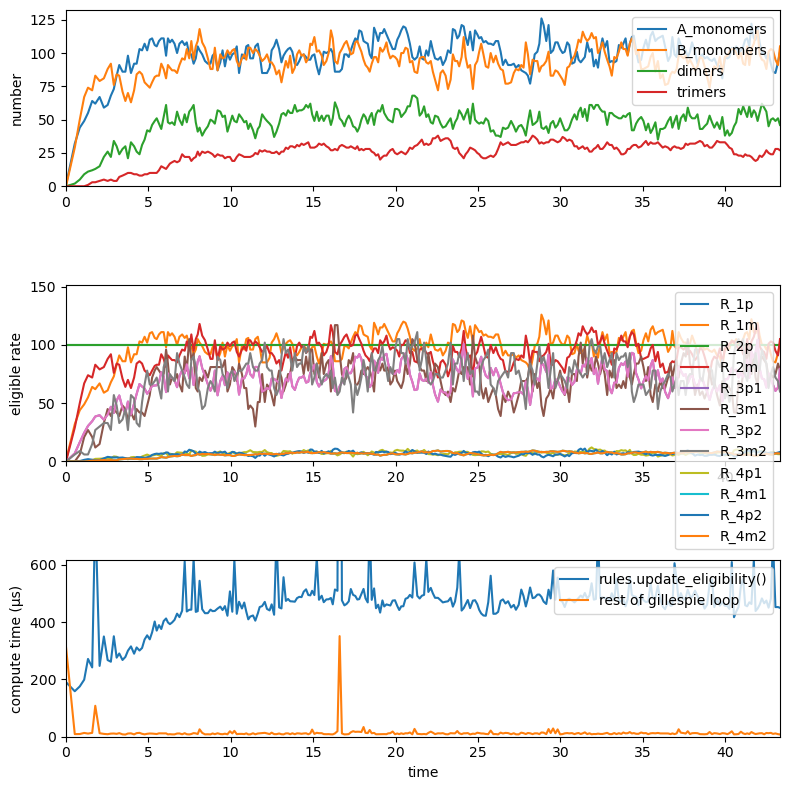

In [3]:
A = space.field_dict['A']
C = space.field_dict['C']
a = space.field_dict['a']
b = space.field_dict['b']
c = space.field_dict['c']
J = space.field_dict['J']
K = space.field_dict['K']

def summary_stats_func():
    stats_dict = dict(
        A_monomers=len(A.indices - (a.indices | b.indices)),
        B_monomers=len(C.indices - c.indices),
        dimers=len(A.indices & ((a.indices - b.indices) |  (b.indices - a.indices))),
        trimers=len(A.indices & (a.indices & b.indices)),
    )
    return stats_dict

# Define, initialize, and run simulation
sim = fg.Simulation(space=space, rules=rules, custom_stats_func=summary_stats_func)
sim.initialize_state()
sim.run(num_steps=30_000, record_every=100)

# Show simulation stats
fgv.show_sim_stats(sim, x_is_time=True)

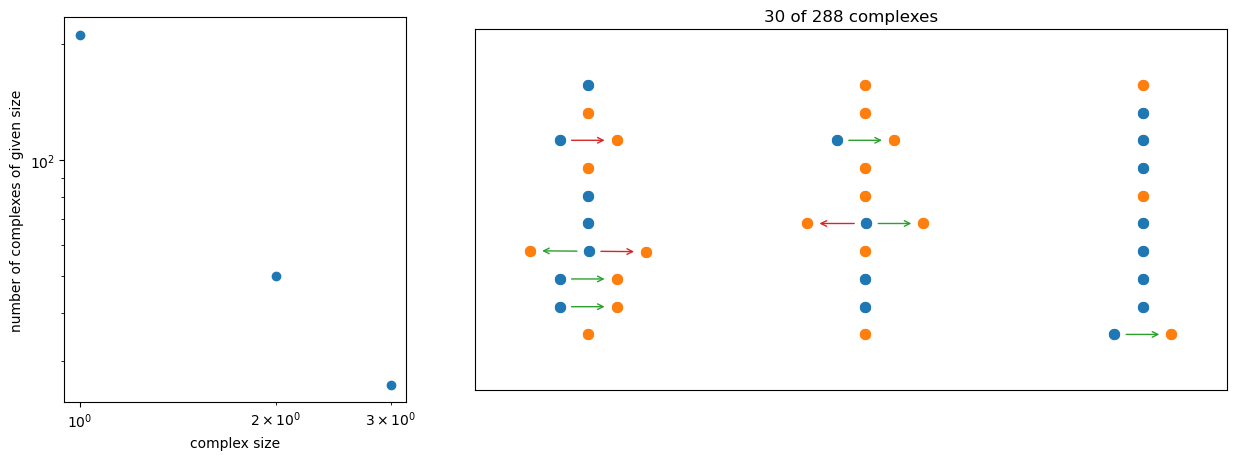

In [4]:
# Compute nodes and edges
nodes=[(f'A_{i[0]}',{'class':'A'}) for i in A.indices] + [(f'C_{i[0]}', {'class':'C'}) for i in C.indices]
edges=[(f'A_{i}', f'C_{j}', {'class':'J'}) for i,j in J.indices] + [(f'A_{i}', f'C_{j}', {'class':'K'}) for i,j in K.indices] 

# Specify properties for visualize_complexes
node_properties={
    'A': {'node_color': 'C0', 'node_shape': 'o', 'node_size':50},
    'C': {'node_color': 'C1', 'node_shape': 'o', 'node_size':50},
}
edge_properties= {
    'J': {'edge_color': 'C2', 'width': 1, 'arrowstyle': '->', 'arrowsize': 10},
    'K': {'edge_color': 'C3', 'width': 1, 'arrowstyle': '->', 'arrowsize': 10}
}

# Make figure
fig = plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(1, 3, figure=fig)

# Plot complex sizes
ax = fig.add_subplot(gs[0, 0])
fgv.show_complex_sizes(nodes, edges, ax=ax)

# Illustrate complexes
ax = fig.add_subplot(gs[0, 1:])
fgv.visualize_complexes(
    nodes=nodes,
    edges=edges,
    node_properties=node_properties,
    edge_properties=edge_properties,
    grid_shape=(10,3),
    x_spacing=5,
    y_spacing=0.5,
    ax=ax,
    iterations=1000,
    learning_rate=0.1)